# MODELO DE DETECÇÃO DE FRAUDE

Para o seguinte projeto será usada uma base de dados do Kaggle chamada [Fraud Detection Example](https://www.kaggle.com/gopalmahadevan/fraud-detection-example) e ela tem uma fração de dados do [PaySim](https://github.com/EdgarLopezPhD/PaySim), um simulador de dados financeiros feito exatamente para detecção de fraude. <p>
    Serão testados diversos modelos de classificação com objetivo de definir mais eficientes de acordo com o objetivo de negócio. <p>
    O projeto será organizado de acordo com o framework CRISP-DM, que possui as seguintes etapas conforme a imagem abaixo:

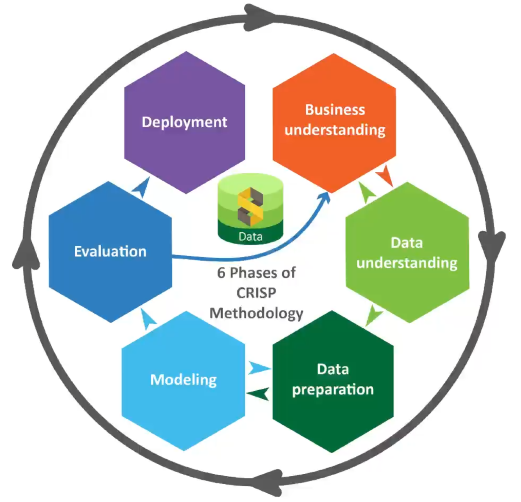

# Business Understanding

# Data Understanding

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando os dados
df = pd.read_csv('fraud_dataset_example.csv')
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [3]:
# Analisando o tamanho do dataset
df.shape

(101613, 11)

In [4]:
# Analisando a qualidade dos dados (dados nulos, tipo de variável)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            101613 non-null  int64  
 1   type            101613 non-null  object 
 2   amount          101613 non-null  float64
 3   nameOrig        101613 non-null  object 
 4   oldbalanceOrg   101613 non-null  float64
 5   newbalanceOrig  101613 non-null  float64
 6   nameDest        101613 non-null  object 
 7   oldbalanceDest  101613 non-null  float64
 8   newbalanceDest  101613 non-null  float64
 9   isFraud         101613 non-null  int64  
 10  isFlaggedFraud  101613 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


In [5]:
# Entendendo as features (11 colunas)
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Descrição de cada variável (de acordo com o kaggle):

**step** - mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo é 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. 
(caixa-de-entrada, caixa-de-saida, débito, pagamento e transferência)

**amount** - valor da transação em moeda local.

**nameOrig** - cliente que iniciou a transação

**oldbalanceOrg** - saldo inicial antes da transação

**newbalanceOrig** - novo saldo após a transação

**nameDest** - cliente que é o destinatário da transação

**oldbalanceDest** - destinatário do saldo inicial antes da transação. 
Observe que não há informações para clientes que começam com M (Comerciantes).

**newbalanceDest** - novo destinatário do saldo após a transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**isFraud** - São as transações feitas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar ao assumir o controle das contas dos clientes e tentar esvaziar os fundos transferindo para outra conta e depois sacando do sistema.

**isFlaggedFraud** - O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.

In [6]:
# Reorganizando as colunas
# Deixaremos as colunas de fradue no início do dataset
df = df[['isFraud',
       'isFlaggedFraud', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest']]
df.head()

isFraud  isFlaggedFraud  step      type    amount     nameOrig  \
0        0               0     1   PAYMENT   9839.64  C1231006815   
1        0               0     1   PAYMENT   1864.28  C1666544295   
2        1               0     1  TRANSFER    181.00  C1305486145   
3        1               0     1  CASH_OUT    181.00   C840083671   
4        0               0     1   PAYMENT  11668.14  C2048537720   

   oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  
0       170136.0       160296.36  M1979787155             0.0             0.0  
1        21249.0        19384.72  M2044282225             0.0             0.0  
2          181.0            0.00   C553264065             0.0             0.0  
3          181.0            0.00    C38997010         21182.0             0.0  
4        41554.0        29885.86  M1230701703             0.0             0.0

In [7]:
# Renomeando as colunas para melhor compreensão dos dados
# Criando um dicionário com os nomes antigos e novos das colunas
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud':'super_fraude',
    'step':'tempo',
    'type':'tipo',
    'amount':'valor',
    'nameOrig':'cliente1',
    'oldbalanceOrg':'saldo_inicial_c1',
    'newbalanceOrig':'novo_saldo_c1',
    'nameDest':'cliente2',
    'oldbalanceDest':'saldo_inicial_c2',
    'newbalanceDest':'novo_saldo_c2',
}

In [8]:
df = df.rename(columns = colunas)
df.head()

fraude  super_fraude  tempo      tipo     valor     cliente1  \
0       0             0      1   PAYMENT   9839.64  C1231006815   
1       0             0      1   PAYMENT   1864.28  C1666544295   
2       1             0      1  TRANSFER    181.00  C1305486145   
3       1             0      1  CASH_OUT    181.00   C840083671   
4       0             0      1   PAYMENT  11668.14  C2048537720   

   saldo_inicial_c1  novo_saldo_c1     cliente2  saldo_inicial_c2  \
0          170136.0      160296.36  M1979787155               0.0   
1           21249.0       19384.72  M2044282225               0.0   
2             181.0           0.00   C553264065               0.0   
3             181.0           0.00    C38997010           21182.0   
4           41554.0       29885.86  M1230701703               0.0   

   novo_saldo_c2  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [9]:
# Análise preliminar da distribuição dos dados
df.describe().T

count          mean           std   min       25%  \
fraude            101613.0  1.141586e-03  3.376824e-02  0.00      0.00   
super_fraude      101613.0  0.000000e+00  0.000000e+00  0.00      0.00   
tempo             101613.0  8.523457e+00  1.820681e+00  1.00      8.00   
valor             101613.0  1.740901e+05  3.450199e+05  0.32  10016.59   
saldo_inicial_c1  101613.0  9.071753e+05  2.829575e+06  0.00      0.00   
novo_saldo_c1     101613.0  9.234992e+05  2.867319e+06  0.00      0.00   
saldo_inicial_c2  101613.0  8.810428e+05  2.399949e+06  0.00      0.00   
novo_saldo_c2     101613.0  1.183998e+06  2.797761e+06  0.00      0.00   

                       50%         75%          max  
fraude                0.00        0.00         1.00  
super_fraude          0.00        0.00         0.00  
tempo                 9.00       10.00        10.00  
valor             53385.41   212498.40  10000000.00  
saldo_inicial_c1  20190.47   194715.00  38939424.03  
novo_saldo_c1         0.00   219217.76  38946233.02  
saldo_inicial_c2  21058.00   591921.70  34008736.98  
novo_saldo_c2     51783.43  1063121.64  38946233.02

In [10]:
# Verificando a variável target
df.groupby('fraude').tempo.count()

fraude
0    101497
1       116
Name: tempo, dtype: int64

In [11]:
# Confirmando a não existência de valores nulos no dataset
df.isnull().values.any()

False

# Data Preparation

Para otimizar o processo de análise dos dados, utilizaremos a função Profiling da biblioteca Pandas.

Instalando o Pandas Profiling

!pip install -U pandas-profiling

## Pandas Profiling

In [12]:
from pandas_profiling import ProfileReport

df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
df.super_fraude.unique()

array([0], dtype=int64)

Podemos observar que a variável 'super_fraude' não possui nenhum valor, ou seja, não temos registros de tranferências maiores que 200 mil no dataset.

## Encoding

Como temos uma variável categórica no dataset ('tipo'), precisamos aplicar uma transformação para transformá-la em numérica. Utilizaremos a função get_dummies da biblioteca Pandas.

In [14]:
df = pd.get_dummies(data=df, columns=['tipo'])
df.head()

fraude  super_fraude  tempo     valor     cliente1  saldo_inicial_c1  \
0       0             0      1   9839.64  C1231006815          170136.0   
1       0             0      1   1864.28  C1666544295           21249.0   
2       1             0      1    181.00  C1305486145             181.0   
3       1             0      1    181.00   C840083671             181.0   
4       0             0      1  11668.14  C2048537720           41554.0   

   novo_saldo_c1     cliente2  saldo_inicial_c2  novo_saldo_c2  tipo_CASH_IN  \
0      160296.36  M1979787155               0.0            0.0             0   
1       19384.72  M2044282225               0.0            0.0             0   
2           0.00   C553264065               0.0            0.0             0   
3           0.00    C38997010           21182.0            0.0             0   
4       29885.86  M1230701703               0.0            0.0             0   

   tipo_CASH_OUT  tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0              0           0             1              0  
1              0           0             1              0  
2              0           0             0              1  
3              1           0             0              0  
4              0           0             1              0

## Removendo variáveis

Identificamos também, a necessidade de remoção de algumas variáveis do dataset antes da criação do modelo, como:

super_fraude -> Possui somente valores nulos.

cliente1 e cliente2 -> Não convém termos o código do cliente em nosso modelo, uma vez que estes não terão nenhum valor preditivo com relação a variável target.

In [15]:
df = df.drop(['cliente1', 'cliente2', 'super_fraude'], axis = 1)
df.head()

fraude  tempo     valor  saldo_inicial_c1  novo_saldo_c1  saldo_inicial_c2  \
0       0      1   9839.64          170136.0      160296.36               0.0   
1       0      1   1864.28           21249.0       19384.72               0.0   
2       1      1    181.00             181.0           0.00               0.0   
3       1      1    181.00             181.0           0.00           21182.0   
4       0      1  11668.14           41554.0       29885.86               0.0   

   novo_saldo_c2  tipo_CASH_IN  tipo_CASH_OUT  tipo_DEBIT  tipo_PAYMENT  \
0            0.0             0              0           0             1   
1            0.0             0              0           0             1   
2            0.0             0              0           0             0   
3            0.0             0              1           0             0   
4            0.0             0              0           0             1   

   tipo_TRANSFER  
0              0  
1              0  
2              1  
3              0  
4              0

# Modeling

## Regressão Logística

In [16]:
# Separando as variáveis independentes e as dependentes
X = df.drop('fraude', axis=1)
y = df[['fraude']]

### Treinando o modelo com divisão simples

In [17]:
from sklearn.model_selection import train_test_split

SEED = 42
# Separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = SEED)

In [18]:
from sklearn.linear_model import LogisticRegression
# Criando o modelo
lr = LogisticRegression(max_iter=1000, random_state=SEED)
# Treinando o modelo
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

Métricas de avaliação:

- Acurácia/Accuracy: avalia a proporção de acertos em relação a todas as previsões realizadas.
- Sensibilidade/Revocação/Recall: avalia a proporção de verdadeiros positivos dentre todos os valores positivos reais.
- Precisão/Precision: avalia a proporção de verdadeiros positivos dentre as predições dadas como positivas pelo modelo.
- F1 Score: é o equilíbrio entre a sensibilidade e a precisão, sendo a média harmônica entre as duas métricas.

In [19]:
from sklearn import metrics

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9989765391276965
Precisão: 0.2
Recall: 0.043478260869565216
F1: 0.07142857142857142


### Treinando o modelo com cross validation

In [20]:
from sklearn.model_selection import cross_validate, ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=SEED)
results = cross_validate(lr, X, y, cv=cv,
                        scoring=['accuracy', 'precision', 'recall', 'f1'])
results

{'fit_time': array([0.58199978, 0.42918396, 0.45799971, 0.4800024 , 0.72423387]),
 'score_time': array([0.01999927, 0.01800251, 0.01999879, 0.026999  , 0.02199864]),
 'test_accuracy': array([0.99897654, 0.99897654, 0.99905527, 0.99897654, 0.9990159 ]),
 'test_precision': array([0.2       , 0.54545455, 0.16666667, 0.5       , 1.        ]),
 'test_recall': array([0.04347826, 0.22222222, 0.05      , 0.11538462, 0.10714286]),
 'test_f1': array([0.07142857, 0.31578947, 0.07692308, 0.1875    , 0.19354839])}

In [21]:
accuracy = sum(results['test_accuracy']) / len(results['test_accuracy'])
precision = sum(results['test_precision']) / len(results['test_precision'])
recall = sum(results['test_recall']) / len(results['test_recall'])
f1 = sum(results['test_f1']) / len(results['test_f1'])

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall) 
print("F1:", f1)

Acurácia: 0.9990001574555188
Precisão: 0.4824242424242424
Recall: 0.10764559112385197
F1: 0.16903790182652662


Analisando os resultados de ambos os métodos de separação dos dados, nota-se que nos dois casos temos um alto valor de acurácia, porém, um f1 score muito baixo, o que nos diz que talvez nossa acurária não seja tão confiável assim, e que temos algum problema com nossos dados.

Vamos analisar então outra métrica, a matriz de confusão.

### Matriz de confusão

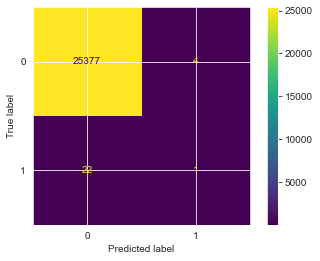

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Podemos ver então, pela matriz de confusão, que o número de verdadeiros negativos é muito maior que o de verdadeiros positivos.

Isso pode estar acontecendo provavelmente porque nossas classes estão desbanlanceadas, temos muito mais exemplos de 'não fraudes' do que 'fraudes' em nosso dataset.

Iremos então utilizar outra métrica para verificar no nosso modelo, a curva ROC.

### Curva ROC

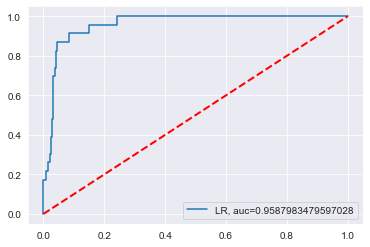

In [23]:
y_pred_proba = lr.predict_proba(X_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

## Balanceando os dados

Para resolver nosso problema de desbalanceamento dos dados iremos utilizar a técnica de Oversampling, que consiste em aumentar a quantidade de valores da classe com menor quantidade de valores, fazendo com que o conjunto de dados aumente e as classes se tornem balanceadas.

Para realizar o Oversampling, iremos utilizar a técnica SMOTE, que consiste em sintetizar novas informações com base nas já existentes, para isto, esta técnica utiliza o algorítmo KNN, que busca os vizinhos mais próximos dos dados já existentes (116 fraudes) e gera novos valores próximos destes.

In [24]:
# !pip install --user -U imbalanced-learn

In [25]:
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.neighbors import DistanceMetric

SEED=42
smote = SMOTE(random_state=42)

In [26]:
X = df.drop('fraude', axis=1)
y = df['fraude']

In [27]:
X_resampled, y_resampled = smote.fit_resample(X,y)

In [28]:
df_balanced = pd.concat([y_resampled, X_resampled], axis=1)
df_balanced

fraude  tempo          valor  saldo_inicial_c1  novo_saldo_c1  \
0            0      1    9839.640000     170136.000000      160296.36   
1            0      1    1864.280000      21249.000000       19384.72   
2            1      1     181.000000        181.000000           0.00   
3            1      1     181.000000        181.000000           0.00   
4            0      1   11668.140000      41554.000000       29885.86   
...        ...    ...            ...               ...            ...   
202989       1      5   17608.962863      17608.962863           0.00   
202990       1      7   12116.291013      12116.291013           0.00   
202991       1      1  231612.880715     231612.880715           0.00   
202992       1      9  547325.144758     547325.144758           0.00   
202993       1      4  159298.594420     159298.594420           0.00   

        saldo_inicial_c2  novo_saldo_c2  tipo_CASH_IN  tipo_CASH_OUT  \
0               0.000000       0.000000             0              0   
1               0.000000       0.000000             0              0   
2               0.000000       0.000000             0              0   
3           21182.000000       0.000000             0              1   
4               0.000000       0.000000             0              0   
...                  ...            ...           ...            ...   
202989          0.000000       0.000000             0              0   
202990          0.000000       0.000000             0              0   
202991       1945.589357    9370.603471             0              0   
202992          0.000000       0.000000             0              0   
202993          0.000000       0.000000             0              0   

        tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0                0             1              0  
1                0             1              0  
2                0             0              1  
3                0             0              0  
4                0             1              0  
...            ...           ...            ...  
202989           0             0              1  
202990           0             0              1  
202991           0             0              0  
202992           0             0              1  
202993           0             0              1  

[202994 rows x 12 columns]

In [29]:
# Verificando o balanceamento dos dados
df_balanced.groupby('fraude').tempo.count()

fraude
0    101497
1    101497
Name: tempo, dtype: int64

### Novo teste com Regressão Logística

In [59]:
X = df_balanced.drop('fraude', axis=1)
y = df_balanced[['fraude']]

In [60]:
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = SEED)

In [32]:
lr = LogisticRegression(max_iter=1000, random_state=SEED)

lr.fit(X_train, y_train)
y_pred =lr.predict(X_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9417722516699837
Precisão: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975


### Cross Validation

In [33]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=SEED)
results = cross_validate(lr, X, y, cv=cv,
                        scoring=['accuracy', 'precision', 'recall', 'f1'])

accuracy = sum(results['test_accuracy']) / len(results['test_accuracy'])
precision = sum(results['test_precision']) / len(results['test_precision'])
recall = sum(results['test_recall']) / len(results['test_recall'])
f1 = sum(results['test_f1']) / len(results['test_f1'])

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall) 
print("F1:", f1)

Acurácia: 0.9417919564917534
Precisão: 0.9257532789278216
Recall: 0.9609059011668414
F1: 0.94300141099313


Podemos observar que as métricas melhoraram bastante após a aplicação do Oversampling em nosso dataset. Temos agora uma boa acurácia e f1 score, trazendo maior confiabilidade nos resultados do nosso modelo.

Tanto a separação dos dados simples em treino e teste, quanto a validação cruzada, geraram resultados bem próximos.

### Confusion Matrix

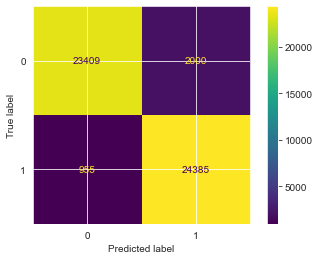

In [34]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Pela matriz de confusão, podemos ver que os dados estão bem balanceados, uma vez que o modelo traz um resultado próximo entre o número de verdadeiros positivos e verdadeiros negativos.

### Curva ROC

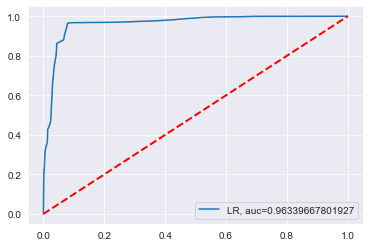

In [35]:
y_pred_proba = lr.predict_proba(X_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

Nossa curva ROC também apresentou melhores resultados, pois temos uma curva mais suave e que cresce mais rápido.

## Seleção de Classificador

In [36]:
# !pip install xgboost

In [37]:
# Treinamento e validação dos Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    'KNN': KNeighborsClassifier(),
    'RegressãoLogística': LogisticRegression(),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoost': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'RedesNeurais': MLPClassifier()
}
# 'SVM': SVC()

In [38]:
# Biblioteca para criar uma barra de progresso
from tqdm.notebook import tqdm_notebook
pbar1 = tqdm_notebook(total=len(models.values()), desc='Progress:')

# Treinando cada um dos modelos
for model in models.values():
    pbar1.update()
    model.fit(X_train, y_train);

Progress::   0%|          | 0/8 [00:00<?, ?it/s]

In [39]:
nome = []
accuracy = []
precision = []
recall = []
f1 = []

pbar2 = tqdm_notebook(total=len(models.items()), desc='Progress:')
# Predizendo os resultados para cada um dos modelos
for name, model in models.items():
    pbar2.update()
    y_pred = model.predict(X_test)
    nome.append(name)
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    precision.append(metrics.precision_score(y_test, y_pred))
    recall.append(metrics.recall_score(y_test, y_pred))
    f1.append(metrics.f1_score(y_test, y_pred))
    print('-------------------------')
    print(name + ":\n Acurácia : {:.5f}\n Precisão: {:.5F}\n Recall: {:.5F}\n f1: {:.5F}".format(metrics.accuracy_score(y_test,y_pred),
                                                                                                 metrics.precision_score(y_test,y_pred),
                                                                                                 metrics.recall_score(y_test,y_pred),
                                                                                                 metrics.f1_score(y_test, y_pred)))
    print('-------------------------')

Progress::   0%|          | 0/8 [00:00<?, ?it/s]

-------------------------
KNN:
 Acurácia : 0.98881
 Precisão: 0.97896
 Recall: 0.99905
 f1: 0.98891
-------------------------
-------------------------
RegressãoLogística:
 Acurácia : 0.94177
 Precisão: 0.92420
 Recall: 0.96231
 f1: 0.94287
-------------------------
-------------------------
NaiveBayes:
 Acurácia : 0.61402
 Precisão: 0.56524
 Recall: 0.98339
 f1: 0.71786
-------------------------
-------------------------
DecisionTree:
 Acurácia : 0.99823
 Precisão: 0.99764
 Recall: 0.99882
 f1: 0.99823
-------------------------
-------------------------
RandomForest:
 Acurácia : 0.99925
 Precisão: 0.99882
 Recall: 0.99968
 f1: 0.99925
-------------------------
-------------------------
GradientBoost:
 Acurácia : 0.98865
 Precisão: 0.98360
 Recall: 0.99384
 f1: 0.98869
-------------------------
-------------------------
XGBoost:
 Acurácia : 0.99911
 Precisão: 0.99838
 Recall: 0.99984
 f1: 0.99911
-------------------------
-------------------------
RedesNeurais:
 Acurácia : 0.96739
 Pre

In [40]:
# Tabela de Métricas por Modelo
teste = pd.DataFrame({'Modelo': nome, 'Accuracy': accuracy, 'Precision': precision, 
                      'Recall': recall, 'f1': f1})
teste.sort_values(by='Accuracy', ascending=False)

Modelo  Accuracy  Precision    Recall        f1
4        RandomForest  0.999251   0.998817  0.999684  0.999251
6             XGBoost  0.999113   0.998384  0.999842  0.999113
3        DecisionTree  0.998227   0.997635  0.998816  0.998225
0                 KNN  0.988808   0.978964  0.999053  0.988906
5       GradientBoost  0.988650   0.983596  0.993844  0.988693
7        RedesNeurais  0.967389   0.944622  0.992897  0.968158
1  RegressãoLogística  0.941772   0.924199  0.962313  0.942871
2          NaiveBayes  0.614022   0.565236  0.983386  0.717858

Pode-se observar que o modelo "RandomForest" teve maior acurácia.

De acordo com nosso modelo de negócio, devemos olhar também para o 'Recall', pois queremos um modelo que detecte o maior número de fraudes possíveis.

Desta forma, observa-se que o melhor modelo para 'Recall' também é o "RandomForest".

A princípio temos nosso melhor modelo, mas antes de decidir vamos analisar melhor a curva ROC e matriz de confusão de cada um.

## Curva ROC

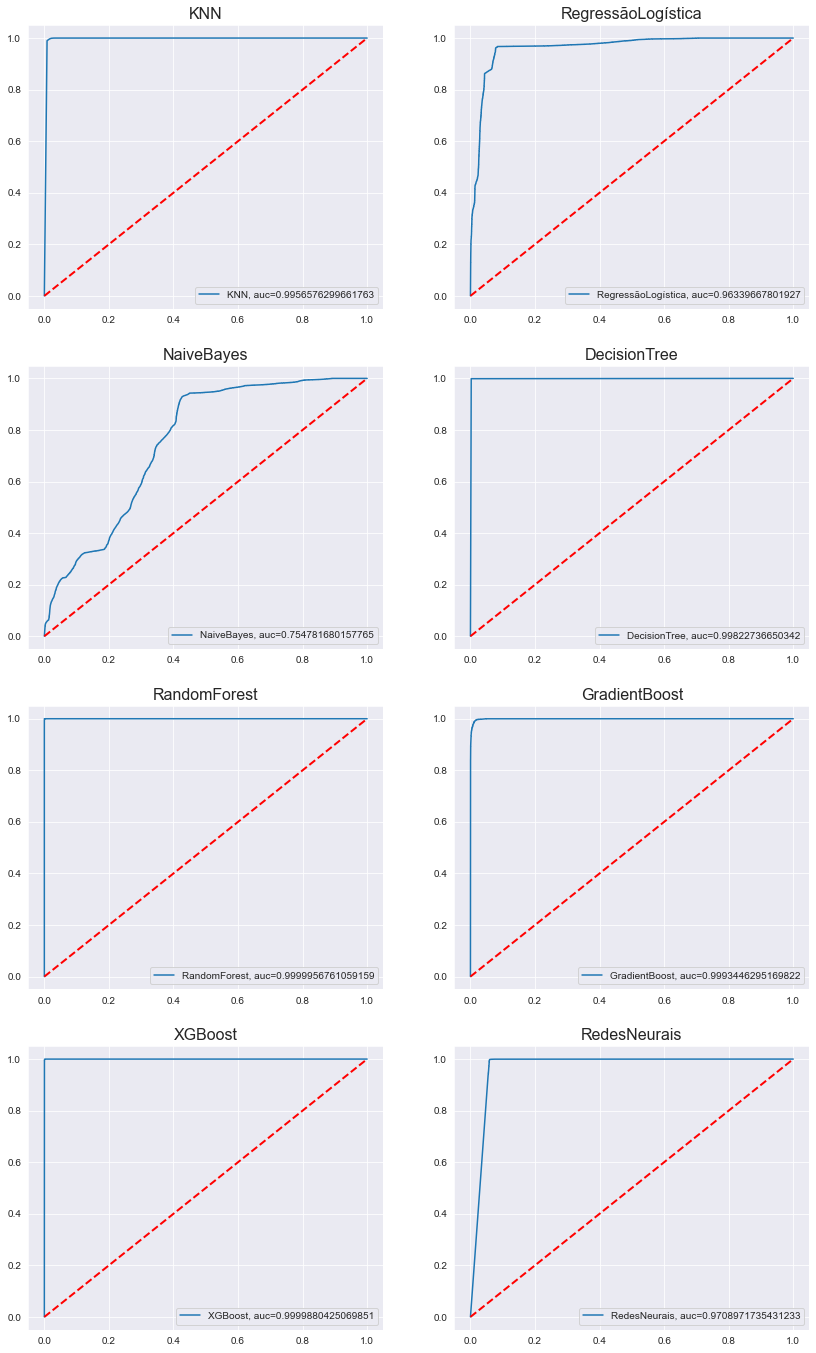

In [41]:
fig = plt.figure(figsize=(14,24))
cont = 1
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[::, 1]
    fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    ax = fig.add_subplot(4,2,cont)
    ax = plt.plot(fpr, tpr, label=name+", auc="+str(auc))
    ax = plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax = plt.title(name, fontsize=16)
    ax = plt.legend(loc=4)
    cont += 1

Dentre os modelos com maior acurácia, todos apresentam uma melhora na curva ROC com relação ao primeiro modelo testado, de Regressão Logística. Porém, a alta acurácia destes modelos devem ser melhor analisadas pois pode-se conter 'Overffiting'.

A fim de apresentarmos o modelo para o nosso cliente, iremos olhar também a matriz de confusão, uma métrica que possui maior interpretabilidade dos resultados.

## Matriz de confusão

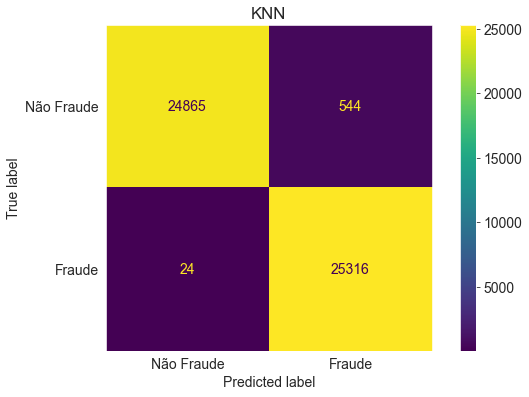

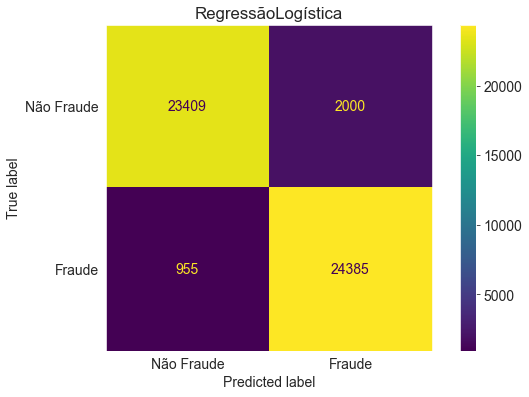

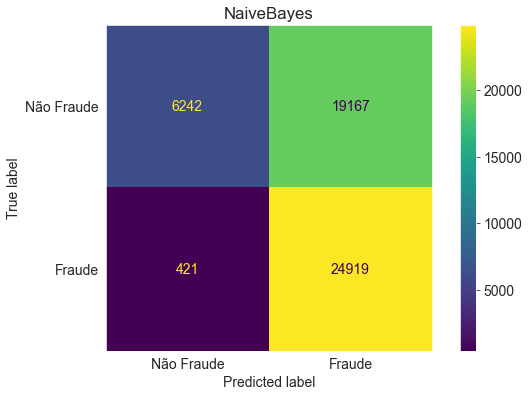

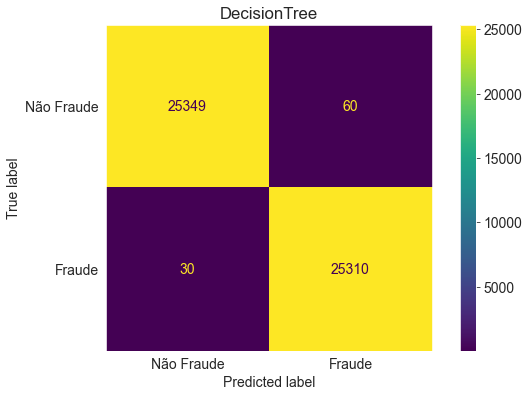

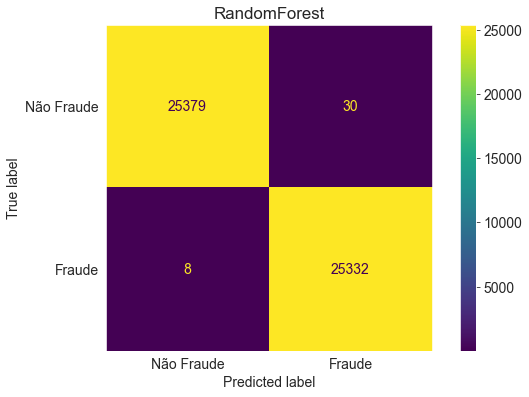

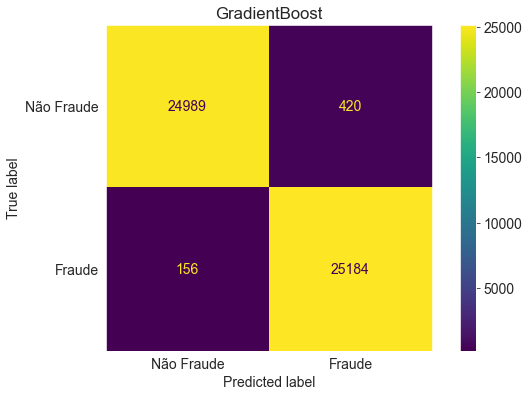

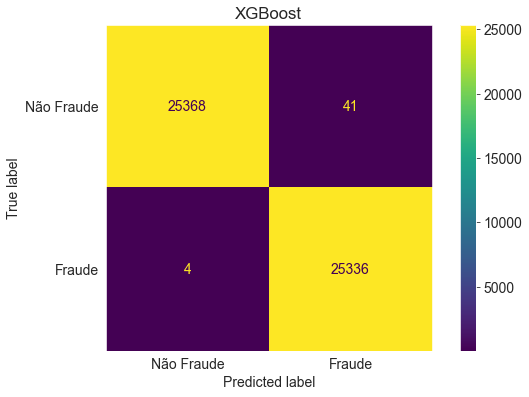

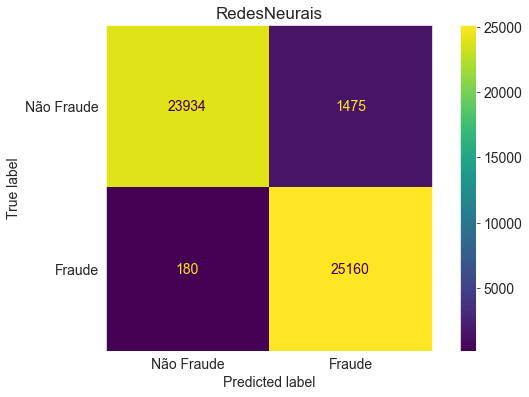

In [42]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['font.size'] = 14

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Fraude', 'Fraude'])
    disp.plot()
    plt.title(name)

Observeva-se que dentre os melhores modelos, o RandomForest apresenta o melhor equilíbrio entre Falso Negativos e Falsos Positivos.

Este é o cenário ideial pois ao reduzirmos Falsos Negativo, garantimos que modelo decteta a maior parte das fraudes. E reduzindo os Falsos Positivos, minimizamos os "Alarmes falsos" passados para os clientes, evitando desgastes do cliente com o Banco.

## Tunning de Hiperparâmetros

Iremos melhorar o modelo RandomForestClassifier utilizando o método RandomizedSearchCV.

In [43]:
# Definindo os hiperparâmetros
n_estimators = np.arange(20, 200, step=20)
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(2, 10, step=1))
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [44]:
param_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [45]:
from sklearn.model_selection import RandomizedSearchCV

SEED = 70
rforest = RandomForestClassifier(random_state=SEED)
random_cv = RandomizedSearchCV(
                rforest, param_grid, n_iter=10, cv=3, scoring="recall", n_jobs=-1, random_state = SEED)

In [46]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
                rforest, param_grid=param_grid, cv=3, scoring="recall", n_jobs=-1)

In [47]:
# !pip install scikit-optimize

In [48]:
from skopt import BayesSearchCV

bayes_search = BayesSearchCV(rforest, search_spaces=param_grid, cv=3, n_jobs=-1)

In [49]:
%%time
rcv = random_cv.fit(X, y)

Wall time: 1min 9s


In [50]:
pd.DataFrame(rcv.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      29.360001      0.216448         0.826667        0.008958   
1      12.800000      0.172106         0.638334        0.034835   
2      11.991334      1.663271         0.281000        0.021278   
3      21.356001      1.529052         0.639334        0.030685   
4      14.410334      0.715366         0.803333        0.017442   
5      23.203391      1.131606         0.620667        0.021171   
6      17.164392      0.110383         0.860370        0.017483   
7      23.502218      0.387265         0.758171        0.054631   
8      12.241773      0.158565         0.281637        0.017654   
9      15.043203      0.531417         0.488979        0.027756   

  param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                120                       4                      2   
1                120                       4                      2   
2                 40                       8                      1   
3                100                       8                      4   
4                160                       6                      2   
5                100                       6                      1   
6                180                       8                      2   
7                180                       2                      1   
8                 60                       4                      2   
9                180                       6                      2   

  param_max_features param_max_depth param_criterion param_bootstrap  \
0               auto               9            gini           False   
1               auto               2            gini           False   
2               sqrt               7         entropy           False   
3               log2               9         entropy            True   
4               log2               2            gini           False   
5               auto               8            gini           False   
6               auto               2         entropy            True   
7               sqrt               7            gini            True   
8               auto               4         entropy           False   
9               log2               2         entropy           False   

                                              params  split0_test_score  \
0  {'n_estimators': 120, 'min_samples_split': 4, ...           0.991665   
1  {'n_estimators': 120, 'min_samples_split': 4, ...           0.914223   
2  {'n_estimators': 40, 'min_samples_split': 8, '...           0.980285   
3  {'n_estimators': 100, 'min_samples_split': 8, ...           0.993497   
4  {'n_estimators': 160, 'min_samples_split': 6, ...           0.914223   
5  {'n_estimators': 100, 'min_samples_split': 6, ...           0.985753   
6  {'n_estimators': 180, 'min_samples_split': 8, ...           0.914223   
7  {'n_estimators': 180, 'min_samples_split': 2, ...           0.978127   
8  {'n_estimators': 60, 'min_samples_split': 4, '...           0.943190   
9  {'n_estimators': 180, 'min_samples_split': 6, ...           0.914223   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.999438           0.992817         0.994640        0.003425   
1           0.936009           0.862704         0.904312        0.030736   
2           1.000000           0.973812         0.984699        0.011138   
3           0.999025           0.992226         0.994916        0.002951   
4           0.943487           0.876537         0.911416        0.027404   
5           0.999675           0.989921         0.991783        0.005834   
6           0.947064           0.862674         0.907987        0.034733   
7           0.999970           0.986019         0.988039        0.009031   
8           0.995980           0.955102         0.964757        0.022607   
9           0.942689           0.862674         0.906529        0.033116   

   rank_test_score  
0     

In [51]:
rcv.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 9,
 'criterion': 'entropy',
 'bootstrap': True}

### Resultados finais

In [52]:
rfn = RandomForestClassifier()

model = rfn.fit(X_train, y_train)
y_pred = rfn.predict(X_test)

In [53]:
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9991921023074346
Precisão: 0.9986596759569519
Recall: 0.9997237569060774
F1: 0.9991914331354645


In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25409
           1       1.00      1.00      1.00     25340

    accuracy                           1.00     50749
   macro avg       1.00      1.00      1.00     50749
weighted avg       1.00      1.00      1.00     50749



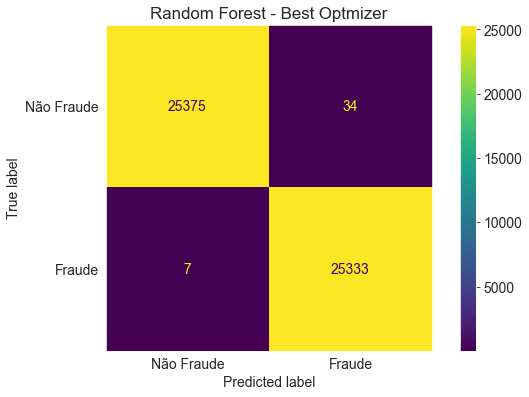

In [55]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Fraude', 'Fraude'])
disp.plot()
plt.title('Random Forest - Best Optmizer')
plt.show()

# Evaluation

## Evaluate results

In [56]:
# !pip install lime

In [57]:
import lime
import lime.lime_tabular

In [89]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=X_train.columns,
                                                   class_names=["fraude"],
                                                   mode='classification')

In [94]:
exp = explainer.explain_instance(X_test.iloc[25],
                                   rfn.predict_proba,
                                   num_features=8,
                                   top_labels=1)

In [95]:
exp.show_in_notebook(show_table=True, show_all=False)

In [64]:
X_test.iloc[25]

tempo                  10.00
valor               18494.97
saldo_inicial_c1        0.00
novo_saldo_c1           0.00
saldo_inicial_c2        0.00
novo_saldo_c2           0.00
tipo_CASH_IN            0.00
tipo_CASH_OUT           0.00
tipo_DEBIT              0.00
tipo_PAYMENT            1.00
tipo_TRANSFER           0.00
Name: 87128, dtype: float64

In [65]:
y_test.iloc[25]

fraude    0
Name: 87128, dtype: int64

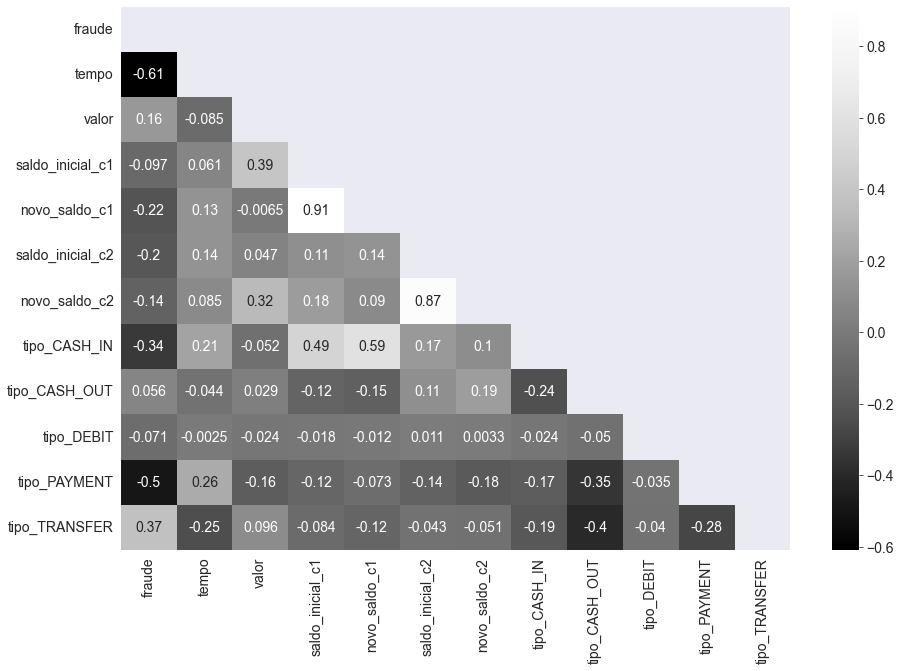

In [87]:
correlation = df_balanced.corr()

# Cria uma máscara para camuflar a parte de cima do mapa
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Plot do mapa de calor
plt.figure(figsize=(15,10))
sns.heatmap(correlation, cmap='Greys_r', mask=mask, square=False, annot=True)
plt.show()

## Review process

## Determine nest steps